In [1]:
# Install split-folders to help organize the data
!pip install split-folders
print("Libraries installed successfully.")

Libraries installed successfully.


In [2]:
from google.colab import files
import os

# Upload kaggle.json
print("Please upload your kaggle.json file:")
uploaded = files.upload()

# Move the token to the correct folder so the API works
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API setup complete!")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Kaggle API setup complete!


In [3]:
# Download the dataset from the link you provided
!kaggle datasets download -d yogeshbandewar/medical-tuborculosis-data

# Unzip the dataset quietly (-q)
!unzip -q medical-tuborculosis-data.zip
print("Dataset downloaded and unzipped.")

Dataset URL: https://www.kaggle.com/datasets/yogeshbandewar/medical-tuborculosis-data
License(s): apache-2.0
 98% 653M/663M [00:10<00:00, 72.9MB/s]
100% 663M/663M [00:11<00:00, 62.9MB/s]
Dataset downloaded and unzipped.


In [4]:
import splitfolders
import os

# 1. Find the folder containing 'Normal' and 'Tuberculosis'
base_path = "."
input_folder = ""

# Walk through directories to find where the class folders are
for root, dirs, files in os.walk(base_path):
    if "Normal" in dirs and ("Tuberculosis" in dirs or "Tuberclosis" in dirs):
        input_folder = root
        break

if input_folder:
    print(f"Found dataset at: {input_folder}")
    # 2. Split the data: 80% for training, 20% for validation
    splitfolders.ratio(input_folder, output="output_dataset", seed=1337, ratio=(.8, .2), group_prefix=None)
    print("Data successfully split into 'output_dataset/train' and 'output_dataset/val'")
else:
    print("Error: Could not automatically find the dataset folders. Please check the files manually.")

Found dataset at: ./Dataset


Copying files: 4200 files [00:02, 1941.54 files/s]

Data successfully split into 'output_dataset/train' and 'output_dataset/val'


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image settings
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# 1. Augment training data (helps model learn better)
train_datagen = ImageDataGenerator(
    rescale=1./255,        # Normalize pixel values (0-1)
    rotation_range=15,     # Rotate images slightly
    zoom_range=0.2,        # Zoom in/out
    horizontal_flip=True,  # Flip left/right
    fill_mode='nearest'
)

# 2. Only rescale validation data (do not change original images)
val_datagen = ImageDataGenerator(rescale=1./255)

# 3. Load data from the split folders
print("Loading Training Data:")
train_generator = train_datagen.flow_from_directory(
    'output_dataset/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

print("Loading Validation Data:")
validation_generator = val_datagen.flow_from_directory(
    'output_dataset/val',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Loading Training Data:
Found 3360 images belonging to 2 classes.
Loading Validation Data:
Found 840 images belonging to 2 classes.


In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# 1. Load VGG16 base model (pre-trained on ImageNet)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# 2. Freeze the base layers so we don't destroy the pre-trained patterns
for layer in base_model.layers:
    layer.trainable = False

# 3. Add our custom layers for TB detection
x = base_model.output
x = GlobalAveragePooling2D()(x)       # Flatten the output
x = Dense(128, activation='relu')(x)  # New hidden layer
x = Dropout(0.5)(x)                   # Dropout to prevent overfitting
output = Dense(1, activation='sigmoid')(x) # Final output (0=Normal, 1=TB)

# 4. Create the final model
model = Model(inputs=base_model.input, outputs=output)

# 5. Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Model structure built successfully.")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Model structure built successfully.


In [7]:
# Early stopping prevents wasting time if the model stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train
history = model.fit(
    train_generator,
    epochs=15,  # You can increase this to 20 if results are not good enough
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 90s 714ms/step - accuracy: 0.7525 - loss: 0.5452 - val_accuracy: 0.8655 - val_loss: 0.2964
Epoch 2/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 71s 673ms/step - accuracy: 0.8737 - loss: 0.2944 - val_accuracy: 0.9286 - val_loss: 0.2048
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 71s 672ms/step - accuracy: 0.9224 - loss: 0.2091 - val_accuracy: 0.9500 - val_loss: 0.1635
Epoch 4/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 70s 666ms/step - accuracy: 0.9299 - loss: 0.1817 - val_accuracy: 0.9619 - val_loss: 0.1356
Epoch 5/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 71s 674ms/step - accuracy: 0.9479 - loss: 0.1467 - val_accuracy: 0.9560 - val_loss: 0.1232
Epoch 6/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 70s 670ms/step - accuracy: 0.9498 - loss: 0.1304 - val_accuracy: 0.9607 - val_loss: 0.1136
Epoch 7/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 70s 670ms/step - accuracy: 0.9561 - loss: 0.1296 - val_accuracy: 0.9714 - val_loss: 0.0911
Epoch 8/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 70s 667ms/step - accuracy: 0.9625 - loss: 0

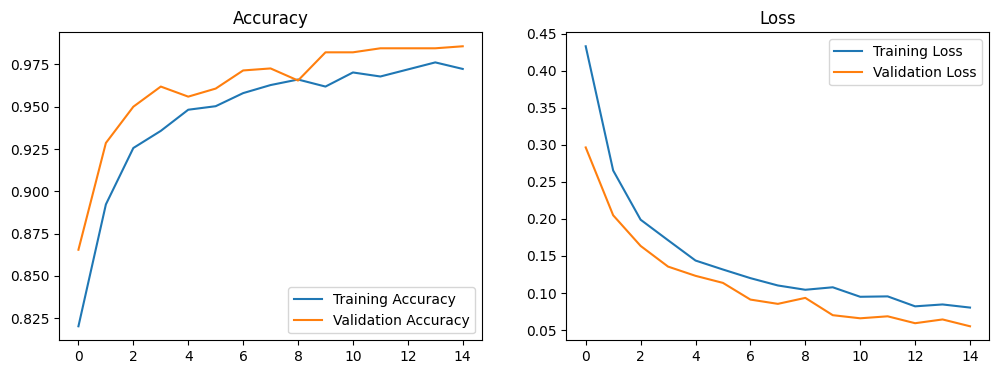

In [8]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [9]:
from google.colab import files

# 1. Save the model to the Colab disk
model_name = 'tb_detection_model.h5'
model.save(model_name)
print(f"Model saved as {model_name}")

# 2. Download the file to your local computer
files.download(model_name)

Model saved as tb_detection_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>